In [4]:
import pynbody

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams

import glob

import sys
sys.path.insert(0, '../util/')
from util_os import util_os

pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane


FileNotFoundError: [Errno 2] No such file or directory: '/home/jw1624/H1-merian/csvs/HI_widths.txt'

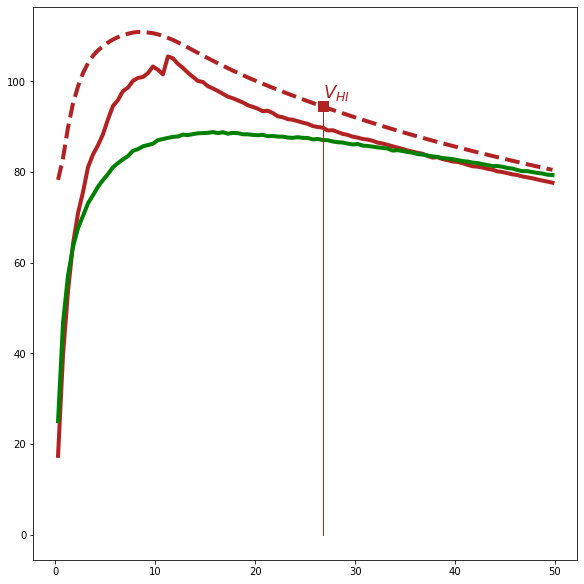

In [5]:
gal = 431

fig,ax = plt.subplots(1,1, layout='constrained', figsize=(8,8), facecolor='w')

# some plotting params 
cdmC = 'firebrick'
sidmC = 'royalblue'
adiabatC = 'g'
lw = 4

# --- let's start with the rotation curves --- 
# profile range
pmin = '0.01 kpc'
pmax = '50 kpc'

cdmFile = util_os.getfilepath_cdm(gal, 0)
adiaFile = util_os.getfilepath_adiabatic(gal)

sCDM = pynbody.load(cdmFile)
sCDM.physical_units()
hCDM = sCDM.halos()[1]

# center based on potential
cen_pot_cdm = pynbody.analysis.halo.center(hCDM, mode='pot', retcen=True)
sCDM['pos'] -= cen_pot_cdm

pynbody.analysis.angmom.faceon(hCDM)

pCDM  = pynbody.analysis.profile.Profile(hCDM,   rmin=pmin, rmax=pmax, type='lin')
pgCDM = pynbody.analysis.profile.Profile(hCDM.g, rmin=pmin, rmax=pmax, type='lin')
pCDM_grav = pynbody.analysis.profile.rotation_curve_spherical(pCDM).in_units(pCDM.sim['vel'].units)
ax.plot(pCDM['rbins'], pCDM['v_circ'], c=cdmC, linewidth=lw)
ax.plot(pCDM['rbins'], pCDM_grav, c=cdmC, linewidth=lw, linestyle='dashed')

#
# adiabatic curve
sA = pynbody.load(adiaFile)
sA.physical_units()
hA = sA.halos()[1]

# center 
cen_pot_a = pynbody.analysis.halo.center(hA, mode='pot', retcen=True)
sA['pos'] -= cen_pot_a

pynbody.analysis.angmom.faceon(hA)

pA = pynbody.analysis.profile.Profile(hA,   rmin=pmin, rmax=pmax, type='lin')
ax.plot(pA['rbins'], pA['v_circ'], c=adiabatC, linewidth=lw)

# 
# get virial radius 
Rvir = pynbody.analysis.halo.virial_radius(sCDM)

#
# get HI radius (radius that encompasses 80% of the HI [NIAHO XVII])
rHI=0
for i in range(len(pgCDM['mass_enc'])):
    if pgCDM['mass_enc'][i] >= 0.9*pgCDM['mass_enc'][-1]:
        rHI=pgCDM['rbins'][i]
        break
    
# plot verticle line at rHI
Vhi = pCDM_grav[i] #Vhi is I velocity at the HI radius
ax.plot([rHI,rHI],[0,Vhi], c=cdmC, linewidth=1)
ax.scatter([rHI], [Vhi], c=cdmC, marker='s', s=100)
ax.text(rHI, Vhi+2, r'$V_{HI}$', c=cdmC, fontsize=18)

#
# read W50 adnd W20 from csv
df = pd.read_csv('/home/jw1624/H1-merian/csvs/HI_widths.txt')
w50 = df['w50_cdm'][df['galaxy']==str(gal)+'_y']
w20 = df['w20_cdm'][df['galaxy']==str(gal)+'_y']

# horizontal line for widths 
ax.plot([0,rHI], [w50/2,w50/2], c='tab:purple', linestyle='dashdot', linewidth=3)
ax.text(rHI+1, w50/2, r'$W_{50}/2$', c='tab:purple', fontsize=15)

ax.plot([0,rHI], [w20/2,w20/2], c='k', linestyle='dashdot', linewidth=3)
ax.text(rHI+1, w20/2, r'$W_{20}/2$', c='k', fontsize=15)


# mark VmaxDMO (adiabatic)
vmax = max(pA['v_circ'])
rvmax = np.where(pA['v_circ'] == max(pA['v_circ']))[0][0]
ax.scatter([pA['rbins'][rvmax]],[vmax], c='g', marker='o', s=120)
#ax.text(pA['rbins'][rvmax],vmax+2, r'$V_{max}^{adiabatic}$', c='g', fontsize=14)

#
# prettify 
ax.set_xlabel('Radius [kpc]', fontsize=22)
ax.set_ylabel('Velocity [km/s]', fontsize=22)

def botToTop(x): return x/Rvir
def topToBot(x): return x*Rvir
secax = ax.secondary_xaxis('top', functions=(botToTop,topToBot))
secax.set_xlabel(r'R$_{vir}$', fontsize=24, fontfamily='serif')

ax.set_xlim([0,0.3*Rvir]) # should be 0.3*virial radius
ax.set_ylim(bottom=0)

ax.text(1,3, 'r'+str(gal), c='k', fontsize=24, weight='bold', fontfamily='serif')

ax.tick_params(axis='both', which='major', labelsize=14)
secax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()

#plt.savefig('../figures/HIProfiles/appendix/nihao_r'+str(gal)+'.png', dpi=600)